In [1]:
import networkx as nx
import numpy as np
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from networkx.algorithms import community
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans
from igraph import Graph
from louvain import find_partition, RBConfigurationVertexPartition
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings("ignore")

C:\Users\MichaelKuzmyn\AppData\Local\Temp\ipykernel_20500\2316832298.py:10: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  from louvain import find_partition, RBConfigurationVertexPartition


# Graph Creation

In [2]:
def read_data(data_path="../data/emails.txt", labels_path="../data/emails_labels.txt"):
    with open(labels_path, "r") as f:
        nodes_labels = f.read()

    nodes_labels = nodes_labels.strip("\n").split("\n")
    nodes = [int(x.split()[0]) for x in nodes_labels]
    labels = [int(x.split()[1]) for x in nodes_labels]

    with open(data_path, "r") as f:
        edges_data = f.read()

    edges = {x: dict() for x in nodes}
    edges = [(int(x.split()[0]), int(x.split()[1])) for x in edges_data.strip("\n").split("\n")]

    return np.array(edges), np.array(nodes), np.array(labels)

In [3]:
def create_graph(edges, nodes):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

In [4]:
e, n, l = read_data()
e.shape, n.shape, l.shape

((25571, 2), (1005,), (1005,))

In [5]:
G = create_graph(e, n)
G.number_of_edges()

25571

# Weight Recalculation

In [6]:
fifth_shortest_paths = {}
edges = list(G.edges())
for edge in edges:
    source, target = edge
    G.remove_edge(source, target)

    shorter_paths = []

    for i in range(8):
        try:
            path = nx.shortest_path(G, source, target)

            shorter_paths.append(path)

            for i in range(len(path) - 1):
                G.remove_edge(path[i], path[i + 1])
        except nx.NetworkXNoPath:
            break

    try:
        fifth_shortest_path = nx.shortest_path(G, source, target)
        fifth_shortest_paths[(source, target)] = fifth_shortest_path
    except nx.NetworkXNoPath:
        fifth_shortest_paths[(source, target)] = []

    for path in shorter_paths:
        for i in range(len(path) - 1):
            G.add_edge(path[i], path[i + 1])

    G.add_edge(source, target)

In [7]:
lengths = []
with open('second_shortest_paths.txt', 'w') as f:
    for pair, path in fifth_shortest_paths.items():
        if path:
            length = len(path) - 1
        else:
            length = 100
        lengths.append(length)
        f.write(f'{pair[0]} {pair[1]} {length}\n')

In [8]:
lengths = np.array(lengths)

In [9]:
for i in range(10):
    print(i, len(np.where(lengths == i)[0]))

print(100, len(np.where(lengths == 100)[0]))

0 642
1 0
2 16218
3 6161
4 366
5 16
6 0
7 0
8 0
9 0
100 2168


In [10]:
G10 = nx.DiGraph()

with open('second_shortest_paths.txt', 'r') as f:
    for line in f:
        source, target, weight = line.split()
        G10.add_edge(source, target, weight=int(weight))

In [11]:
lengths = dict(nx.all_pairs_dijkstra_path_length(G10))

In [12]:
n = len(G10.nodes)
distance_matrix = np.zeros((n, n))
for source, path_lengths in lengths.items():
    for target, distance in path_lengths.items():
        distance_matrix[int(source), int(target)] = distance

# Apply DBSCAN
dbscan = DBSCAN(metric='precomputed', eps=0.1, min_samples=10, algorithm='brute')
labels = dbscan.fit_predict(distance_matrix)

In [13]:
len(np.where(labels != 0)[0])
# len(set(labels))

0

In [14]:
adj_matrix = np.array(nx.to_numpy_array(G))
G_undirected = G.to_undirected()

# Own Approaches

In [15]:
def modularity(G, labels):
    Q = 0
    m = G.number_of_edges()
    for node in G.nodes:
        for neighbor in G.neighbors(node):
            if labels[node] == labels[neighbor]:
                Q += (1 if G.has_edge(node, neighbor) else 0) - G.degree(node) * G.degree(neighbor) / (2 * m)
    return Q / (2 * m)

In [16]:
def compute_binary_assignments(labels):
    binary_assignments = np.zeros((len(labels), len(set(labels))))
    for i in range(len(labels)):
        binary_assignments[i][labels[i]] = 1
    return binary_assignments

In [17]:
def compute_metrics(true_labels, predicted_labels):
    print(f'Modularity: {modularity(G, predicted_labels)}')
    print(f'ARI: {ari(true_labels, predicted_labels)}')
    print(f'NMI: {nmi(true_labels, predicted_labels)}')
    
    # Compute binary assignments for true labels and predicted labels
    binary_true_assignments = compute_binary_assignments(true_labels)
    binary_predicted_assignments = compute_binary_assignments(predicted_labels)
    if binary_true_assignments.shape[1] > binary_predicted_assignments.shape[1]:
        missing_columns = binary_true_assignments.shape[1] - binary_predicted_assignments.shape[1]
        binary_predicted_assignments = np.column_stack([binary_predicted_assignments, np.zeros((binary_predicted_assignments.shape[0], missing_columns))])

    
    print(f'F1: {f1_score(binary_true_assignments, binary_predicted_assignments, average="micro")}')


## Spectral Clustering

In [18]:
true_labels = l

In [19]:
spectral = SpectralClustering(affinity='precomputed', n_clusters=len(set(true_labels))).fit(adj_matrix)
print('Spectral Clustering')
compute_metrics(true_labels, spectral.labels_)
len(set(spectral.labels_))

Spectral Clustering
Modularity: 0.2325665997295664
ARI: 0.07861309007526987
NMI: 0.5051417790168548
F1: 0.010945273631840797


42

## Agglomerative Clustering

In [20]:
agg = AgglomerativeClustering(n_clusters=len(set(true_labels))).fit(adj_matrix)
print('\nAgglomerative Clustering')
compute_metrics(true_labels, agg.labels_)


Agglomerative Clustering
Modularity: 0.10134280902639785
ARI: 0.06261314476375221
NMI: 0.48450687953476
F1: 0.03383084577114428


## Louvain

In [21]:
G_igraph = Graph.from_networkx(G_undirected)

partition = find_partition(G_igraph, RBConfigurationVertexPartition)
louvain_labels = partition.membership
print('\nLouvain Method')
compute_metrics(true_labels, louvain_labels)
len(set(louvain_labels))


Louvain Method
Modularity: 0.2397008697708202
ARI: 0.32350360711468407
NMI: 0.5803406508407216
F1: 0.009950248756218905


27

## Kmeans

In [22]:
kmeans = KMeans(n_clusters=len(set(true_labels))).fit(adj_matrix)
print('\nKMeans')
compute_metrics(true_labels, kmeans.labels_)


KMeans
Modularity: 0.10875862134547906
ARI: 0.026450096222048653
NMI: 0.42321756848029213
F1: 0.06766169154228856


# Plots

In [23]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, f1_score, jaccard_score
from community import modularity


def compute_shortest_paths(G, iterations):
    edges = list(G.edges())
    for edge in edges:
        source, target = edge
        G.remove_edge(source, target)

        shorter_paths = []

        for _ in range(iterations):
            try:
                path = nx.shortest_path(G, source, target)
                shorter_paths.append(path)

                for i in range(len(path) - 1):
                    G.remove_edge(path[i], path[i + 1])
            except nx.NetworkXNoPath:
                break

        try:
            nth_shortest_path = nx.shortest_path(G, source, target)
            nth_shortest_path_length = len(nth_shortest_path) - 1
            G.add_edge(source, target, weight=nth_shortest_path_length)
        except nx.NetworkXNoPath:
            G.add_edge(source, target, weight=100)

        for path in shorter_paths:
            for i in range(len(path) - 1):
                G.add_edge(path[i], path[i + 1])

    return G



In [74]:
def compute_metrics(true_labels, predicted_labels):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='micro')
    jaccard = jaccard_score(true_labels, predicted_labels, average='micro')
    
    # print(f'ARI: {ari}')
    # print(f'__NMI: {nmi}')
    # print(f'F1: {f1}')
    # print(f'Jaccard: {jaccard}')
    
    return ari, nmi, f1, jaccard


In [64]:
iteration_values = range(1, 10)
ari_values = []
nmi_values = []
f1_values = []
jaccard_values = []

true_labels = l

In [65]:
G10 = nx.DiGraph()

with open('second_shortest_paths.txt', 'r') as f:
    for line in f:
        source, target, weight = line.split()
        G10.add_edge(source, target, weight=int(weight))

## Spectral Clustering

In [75]:
print('Spectral Clustering')
for i in iteration_values:
    G = G10.copy()
    G = compute_shortest_paths(G, i)
    
    adj_matrix = nx.to_numpy_array(G)
    
    spectral = SpectralClustering(affinity='precomputed', n_clusters=len(set(true_labels))).fit(adj_matrix)
    ari, nmi, f1, jaccard = compute_metrics(true_labels, spectral.labels_)

    ari_values.append(ari)
    nmi_values.append(nmi)
    f1_values.append(f1)
    jaccard_values.append(jaccard)

Spectral Clustering


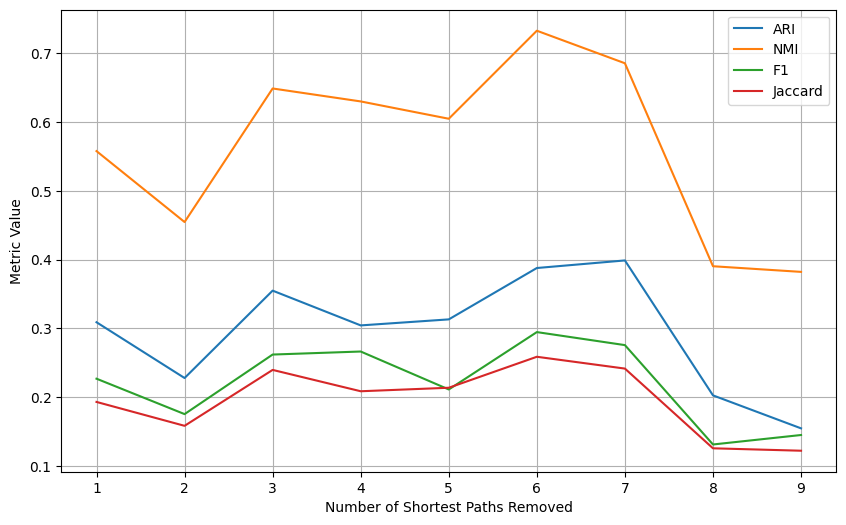

In [67]:
plt.figure(figsize=(10, 6))

plt.plot(iteration_values, ari_values, label='ARI')
plt.plot(iteration_values, nmi_values, label='NMI')
plt.plot(iteration_values, f1_values, label='F1')
plt.plot(iteration_values, jaccard_values, label='Jaccard')

plt.xlabel('Number of Shortest Paths Removed')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

## Louvain

In [68]:
ari_values = []
nmi_values = []
f1_values = []
jaccard_values = []

In [69]:
print('\nLouvain Method')
for i in iteration_values:
    
    G = G10.copy()
    G = compute_shortest_paths(G, i)
    G_undirected = G.to_undirected()
    G_igraph = Graph.from_networkx(G_undirected)
    partition = find_partition(G_igraph, RBConfigurationVertexPartition)
    louvain_labels = partition.membership
    ari, nmi, f1, jaccard = compute_metrics(true_labels, louvain_labels)
    
    ari_values.append(ari)
    nmi_values.append(nmi)
    f1_values.append(f1)
    jaccard_values.append(jaccard)


Louvain Method


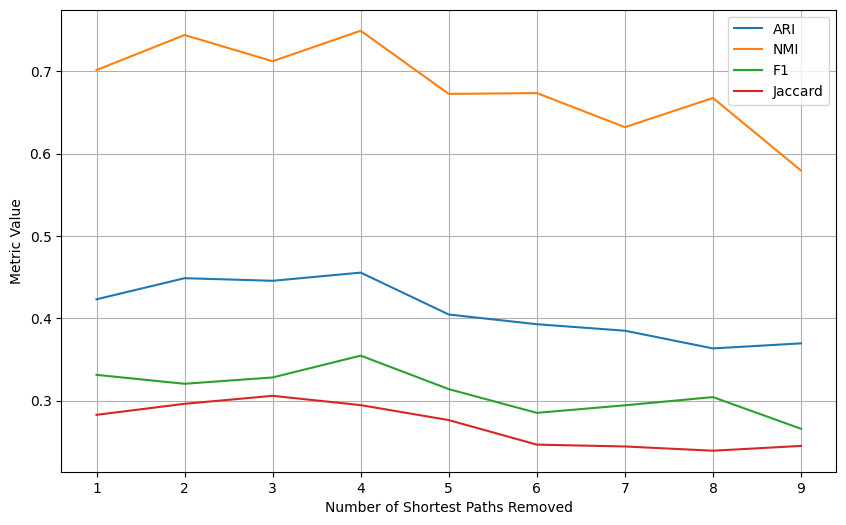

In [70]:
plt.figure(figsize=(10, 6))

plt.plot(iteration_values, ari_values, label='ARI')
plt.plot(iteration_values, nmi_values, label='NMI')
plt.plot(iteration_values, f1_values, label='F1')
plt.plot(iteration_values, jaccard_values, label='Jaccard')

plt.xlabel('Number of Shortest Paths Removed')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

## Agglomerative Clustering

In [71]:
ari_values = []
nmi_values = []
f1_values = []
jaccard_values = []

In [72]:
print('\nAgglomerative Clustering')
for i in iteration_values:
    G = G10.copy()
    G = compute_shortest_paths(G, i)

    adj_matrix = nx.to_numpy_array(G)
    agg = AgglomerativeClustering(n_clusters=len(set(true_labels))).fit(adj_matrix)
    ari, nmi, f1, jaccard = compute_metrics(true_labels, agg.labels_)
    
    ari_values.append(ari)
    nmi_values.append(nmi)
    f1_values.append(f1)
    jaccard_values.append(jaccard)


Agglomerative Clustering


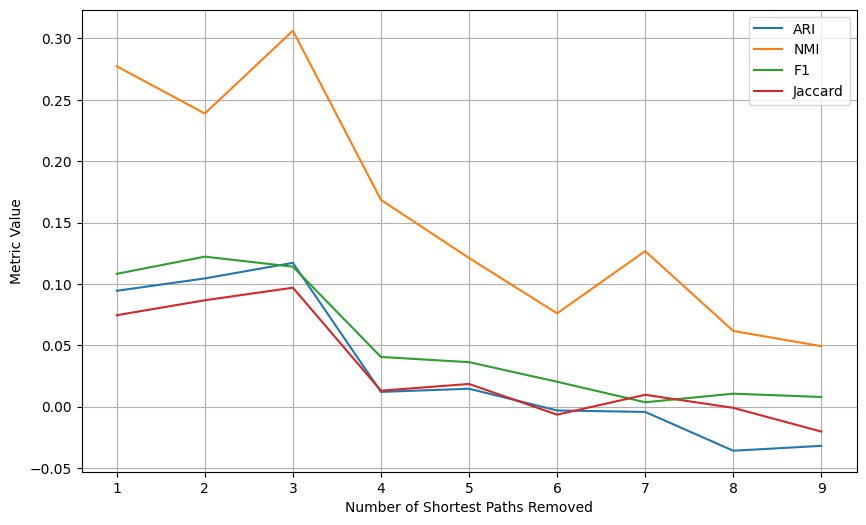

In [73]:
plt.figure(figsize=(10, 6))

plt.plot(iteration_values, ari_values, label='ARI')
plt.plot(iteration_values, nmi_values, label='NMI')
plt.plot(iteration_values, f1_values, label='F1')
plt.plot(iteration_values, jaccard_values, label='Jaccard')

plt.xlabel('Number of Shortest Paths Removed')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()